# ECMWF Reanalysis v5 datan avulla tuulivoiman tuotannon estimointi

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cdsapi
import matplotlib.pyplot as plt
import seaborn as sns
from windpowerlib import ModelChain, WindTurbine
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Säädatan kutsuminen cds:stä
* 10m tuuli ja auringonsäteily koko Suomen alueelle kahden viikon ajalta
* Yksinkertaisuuden vuoksi valitaan 3 pistettä, joissa tuotanto on suurinta ja lasketaan kokonaistuotanto niiden mukaan

In [24]:
dataset = "reanalysis-era5-single-levels-timeseries"
request = {
    "variable": [
        "surface_pressure",
        "2m_temperature",
        "100m_u_component_of_wind",
        "100m_v_component_of_wind"
    ],
    "location": {"longitude": 25, "latitude": 66}, #(21.5, 62.5 = närpiö) (66, 25 = simo) (64, 23.5 = kalajoki)
    "date": ["2025-10-01/2025-10-14"],
    "data_format": "csv"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2026-02-06 13:34:57,945 WARNING [2025-03-17T00:00:00] Please be aware that the generation of this dataset is using an alternative source for the ERA5 data and may be subject to changes over time (e.g. file format, data file structure, deprecation etc). This dataset should therefore be regarded as “experimental” and is **not recommended for use in a production environment**. 

Notification of changes via this catalogue entry banner and/or in the [Forum](https://forum.ecmwf.int/) will be provided on best efforts.

Notification of changes via this catalogue entry banner and/or in the [Forum](https://forum.ecmwf.int/) will be provided on best efforts.
2026-02-06 13:34:57,949 INFO Request ID is 422ada46-13e9-4c3f-875f-b94ce6bb56b0
INFO:ecmwf.datastores.legacy_client:Request ID is 422ada46-13e9-4c3f-875f-b94ce6bb56b0
2026-02-06 13:34:58,037 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-02-06 13:35:11,705 INFO status has 

'40f7a3a6e828fb4a55ddbec464e30de8.zip'

# Kalajoen, närpiön ja simon dataframet

In [2]:
df_k = pd.read_csv("kalajoki.zip")
df_k.set_index("valid_time", inplace=True)
#print(df_k.head())

df_n = pd.read_csv("narpio.zip")
df_n.set_index("valid_time", inplace=True)
print(df_n.head())

df_s = pd.read_csv("simo.zip")
df_s.set_index("valid_time", inplace=True)
print(df_s.head())

                         u100      v100        t2m         sp  latitude  \
valid_time                                                                
2025-10-01 00:00:00  0.425766  6.332184  276.29810  103074.89      62.5   
2025-10-01 01:00:00  0.183731  6.486710  276.37332  103073.20      62.5   
2025-10-01 02:00:00  0.119232  6.377823  275.85962  103085.54      62.5   
2025-10-01 03:00:00 -0.168198  6.372909  275.54360  103069.97      62.5   
2025-10-01 04:00:00 -0.467758  6.192230  275.06800  103079.06      62.5   

                     longitude  
valid_time                      
2025-10-01 00:00:00       21.5  
2025-10-01 01:00:00       21.5  
2025-10-01 02:00:00       21.5  
2025-10-01 03:00:00       21.5  
2025-10-01 04:00:00       21.5  
                         u100      v100        t2m         sp  latitude  \
valid_time                                                                
2025-10-01 00:00:00  3.602524  4.353668  279.84497  102387.89      66.0   
2025-10-01 01:00:0

# Tuulivoiman tuotannon estimointi
* Käytetään windpowerlib -kirjastoa


Kalajoen arvioitu tuotannon keskiarvo (MW):
1882.91600721766

Narpion arvioitu tuotannon keskiarvo (MW):
1918.489965702286

Simon arvioitu tuotannon keskiarvo (MW):
509.19345511033106

Yhteensä arvioitu tuotannon keskiarvo (MW):
4310.5994280302775


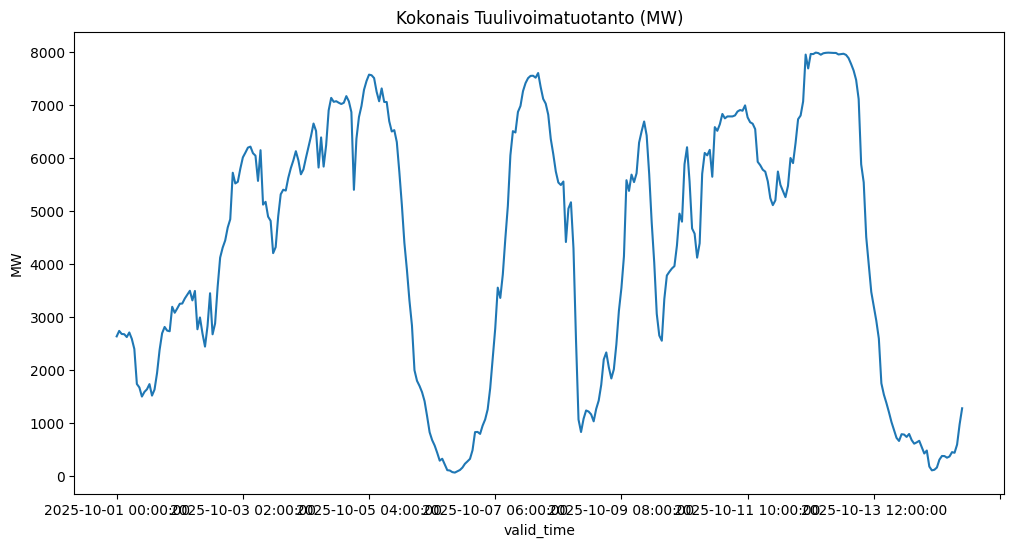

In [ ]:
df_k['wind_speed'] = np.sqrt(df_k['u100']**2 + df_k['v100']**2)
df_k['roughness_length'] = 0.3

df_n['wind_speed'] = np.sqrt(df_n['u100']**2 + df_n['v100']**2)
df_n['roughness_length'] = 0.3

df_s['wind_speed'] = np.sqrt(df_s['u100']**2 + df_s['v100']**2)
df_s['roughness_length'] = 0.3

columns = pd.MultiIndex.from_tuples([
    ('wind_speed', 100),
    ('temperature', 2),
    ('pressure', 0),
    ('roughness_length', 0)
], names=['variable_name', 'height'])

weather_data_k = pd.DataFrame(index=df_k.index, columns=columns)
weather_data_n = pd.DataFrame(index=df_n.index, columns=columns)
weather_data_s = pd.DataFrame(index=df_s.index, columns=columns)

# Sijoitetaan data sarakkeisiin
weather_data_k[('wind_speed', 100)] = df_k['wind_speed']
weather_data_k[('temperature', 2)] = df_k['t2m']
weather_data_k[('pressure', 0)] = df_k['sp']
weather_data_k[('roughness_length', 0)] = df_k['roughness_length']

weather_data_n[('wind_speed', 100)] = df_n['wind_speed']
weather_data_n[('temperature', 2)] = df_n['t2m']
weather_data_n[('pressure', 0)] = df_n['sp']
weather_data_n[('roughness_length', 0)] = df_n['roughness_length']

weather_data_s[('wind_speed', 100)] = df_s['wind_speed']
weather_data_s[('temperature', 2)] = df_s['t2m']
weather_data_s[('pressure', 0)] = df_s['sp']
weather_data_s[('roughness_length', 0)] = df_s['roughness_length']


kalajoki_turbine = WindTurbine(
    hub_height=145,           
    turbine_type='V126/3450'  
)

narpio_turbine = WindTurbine(
    hub_height=155,           # Uudet puistot ovat korkeita (data mediaani 148m, uudet korkeampia)
    turbine_type='V126/3450'  # Tai 'N131/3000' jos N149 puuttuu. Tavoite: Iso roottori!
)

simo_turbine = WindTurbine(
    hub_height=135,           # Matalampi torni kuin uusissa puistoissa
    turbine_type='V126/3450'  
)


model_k = ModelChain(
    kalajoki_turbine, 
    wind_speed_model='logarithmic', # Hellman skaalaus 100m -> 165m
    density_correction=True,       # Huomioi kylmän ilman tiheyden!
    power_output_model='power_curve'
)

model_n = ModelChain(
    narpio_turbine, 
    wind_speed_model='logarithmic', # Hellman skaalaus 100m -> 165m
    density_correction=True,         # Huomioi kylmän ilman tiheyden!
    power_output_model='power_curve'
)

model_s = ModelChain(
    simo_turbine, 
    wind_speed_model='logarithmic', # Hellman skaalaus 100m -> 165m
    density_correction=True,         # Huomioi kylmän ilman tiheyden!
    power_output_model='power_curve'
)

model_k.run_model(weather_data_k)
kalajoki_total_mw = (model_k.power_output / 1000000) * 800 * 4.2 / 3.45

model_n.run_model(weather_data_n)
narpio_total_mw = (model_n.power_output / 1000000) * 600 * 5.7 / 3.45

model_s.run_model(weather_data_s)
simo_total_mw = (model_s.power_output / 1000000) * 350 * 1.0

total_mw = kalajoki_total_mw + narpio_total_mw + simo_total_mw

print("Kalajoen arvioitu tuotannon keskiarvo (MW):")
print(sum(kalajoki_total_mw)/len(kalajoki_total_mw))
print("\nNarpion arvioitu tuotannon keskiarvo (MW):")
print(sum(narpio_total_mw)/len(narpio_total_mw))
print("\nSimon arvioitu tuotannon keskiarvo (MW):")
print(sum(simo_total_mw)/len(simo_total_mw))
print("\nYhteensä arvioitu tuotannon keskiarvo (MW):")
print(sum(total_mw)/len(total_mw))

total_mw.plot(title="Kokonais Tuulivoimatuotanto (MW)", ylabel="MW", figsize=(12, 6))
plt.ylabel("MW")
plt.show()

In [ ]:
df_fingrid = pd.read_csv("tuulivoima_oikea.csv", sep=';', decimal=',', parse_dates=['startTime'])
df_fingrid['startTime'] = pd.to_datetime(df_fingrid['startTime'])

df_fingrid.set_index('startTime', inplace=True)
df_fingrid['value'] = pd.to_numeric(df_fingrid['value'].astype(str).str.replace(',', '.'), errors='coerce')
df_fingrid = df_fingrid['value'].resample('1h').mean()

# Vertaus oikeisiin tuotantoarvoihin


In [ ]:
total_mw_df = total_mw.to_frame(name='mw')
total_mw_df.index = pd.to_datetime(total_mw_df.index)

if total_mw_df.index.tz is None:
    total_mw_df.index = total_mw_df.index.tz_localize('UTC')
else:
    total_mw_df.index = total_mw_df.index.tz_convert('UTC')

comparison_df = pd.merge(total_mw_df, df_fingrid, left_index=True, right_on='startTime', how='inner')

correlation = comparison_df['mw'].corr(comparison_df['value'])
print(f"Korrelaatio: {correlation}")

Korrelaatio: 0.9259613472087309


In [16]:
mae = mean_absolute_error(comparison_df['value'], comparison_df['mw'])
rmse = np.sqrt(mean_squared_error(comparison_df['value'], comparison_df['mw']))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1170.2893919889204
Root Mean Squared Error (RMSE): 1483.108719262528


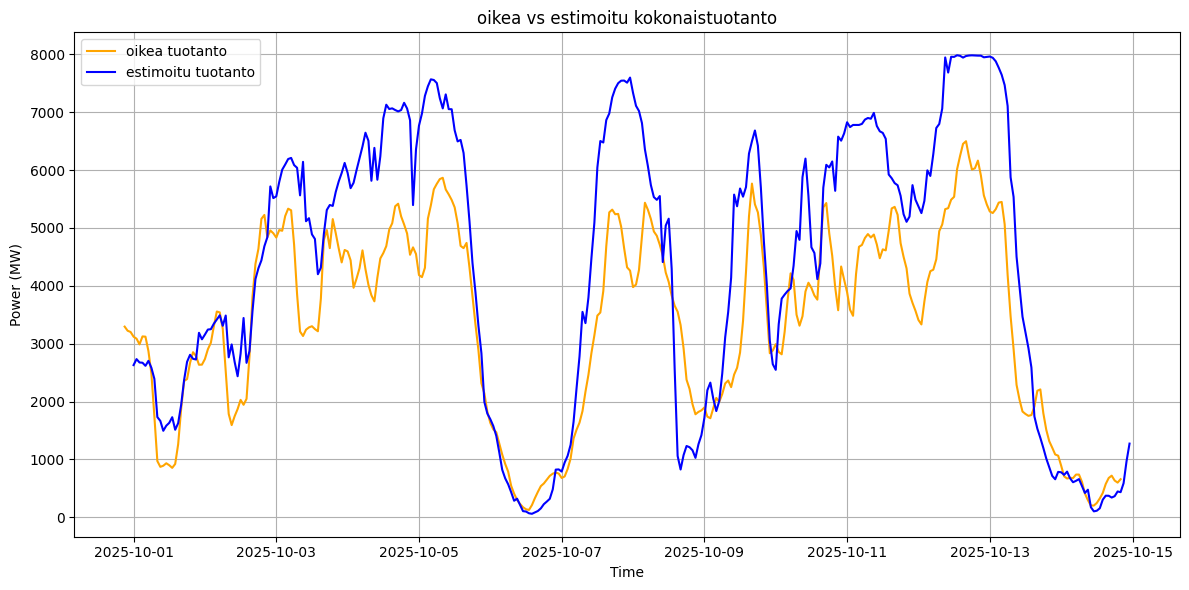

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_fingrid.index, df_fingrid.values, color='orange', label='oikea tuotanto')
plt.plot(total_mw_df.index, total_mw_df.values, color='blue', label='estimoitu tuotanto')
plt.title('oikea vs estimoitu kokonaistuotanto')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()